In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Create the .kaggle directory if it doesn't exist
!mkdir -p /root/.kaggle

# Copy the kaggle.json file from Google Drive to the .kaggle directory
!cp /content/drive/My\ Drive/kaggle.json /root/.kaggle/

# Change the permissions of the kaggle.json file to 600
!chmod 600 /root/.kaggle/kaggle.json


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project Overview
The goal of this project is to demonstrate Uncertanty in Deep learning.  I learned about this topic from https://www.osti.gov/servlets/purl/1733262

# Uncertanty Overview
Uncertanty is a method of showing how confident a ML algoithim is it's predictions.  For instance, in a multiclass model, the model may have .6 for one value, .55 for a second, and .54 for  third.  This could indicate that you model us uncertain but it will always pick the top option.

Uncertanty is diffrent from probability as uncertanty can show that the avaliable information is not sufficient to make a competent selection.

You can use uncertatny to quantify error margins in prediction algorithims as well.  For instance, knowing uncertanty can indicate if your error margin is 1%, 10%, or 50%.  It can also let you attempt to correct for your error margin.

# Project Plan
I plan to revisit the Histographic Cancer Detection Kaggle competetion.  I will create very basic CNN to predict the results, and then quantify and demonstrate uncertatny.  After that, I will attempt to correct to minimise uncertatny, and show how uncertanty can be used to quantify error.

## ChatGPT/GEMINI Use
I will be using ChatGPT in this project to generate code for non-ai model purposes such as data ingest and visualizaiton.

## This project was develed and run on Google Colab

In [3]:
import kaggle
import tensorflow as tf
import keras
import zipfile
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# Download the dataset
!kaggle datasets download returnofsputnik/chihuahua-or-muffin

#Unzip the dataset
#shutil.copy('drive/MyDrive/Uncertanty/muffin-vs-chihuahua-image-classification', '.')
with zipfile.ZipFile('chihuahua-or-muffin.zip', 'r') as zip_ref:
    zip_ref.extractall()


Dataset URL: https://www.kaggle.com/datasets/returnofsputnik/chihuahua-or-muffin
License(s): unknown
chihuahua-or-muffin.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
imagesize = 169
def process_files_in_folder(folder_path):
  images = []
  labels = []
  for filename in os.listdir(folder_path):
      if filename.endswith('.jpg') or filename.endswith('.jpeg'):
        if 'muffin' in filename:
          labels.append(1)
        else:
          labels.append(0)
        image = Image.open(os.path.join(folder_path, filename))
        image = image.resize((imagesize, imagesize))
        images.append(np.array(image))
  return pd.DataFrame({'image': images, 'label': labels})
train = process_files_in_folder('.')


In [7]:
# God I love google code autocomplete
# This exists to ingest the files and add them to the list of images
def process_files_in_folder(folder_path, label):
    processed_files = pd.DataFrame(columns=['image', 'label'])
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            labels.append(label)
            file_path = os.path.join(folder_path, filename)
            print(np.array(Image.open(file_path)).shape)
            images.append(np.array(Image.open(file_path)) / 255.0)
    processed_files = pd.DataFrame({'image': images, 'label': labels})
    return processed_files

train = process_files_in_folder('train/chihuahua/', 0)
train = pd.concat([train,process_files_in_folder('train/muffin/', 1)])
train = pd.concat([train,process_files_in_folder('test/chihuahua/', 0)])
train = pd.concat([train,process_files_in_folder('test/muffin/', 1)])


FileNotFoundError: [Errno 2] No such file or directory: 'train/chihuahua/'

In [9]:
#Convert To Numpy
train_data = np.stack(train['image'].to_list(),axis = 0)
train_targets = np.stack(train['label'].to_list(),axis = 0)
#Save Numpy to file for faster loading later
h5f = h5py.File('image_data.h5', 'w')
h5f.create_dataset('train_data', data=train_data)
h5f.create_dataset('train_targets', data=train_targets)
h5f.close()
del train
shutil.copy('image_data.h5', 'drive/MyDrive/Uncertanty/image_data.h5')

'drive/MyDrive/Uncertanty/image_data.h5'

In [10]:
shutil.copy('drive/MyDrive/Uncertanty/image_data.h5', '.')
h5f = h5py.File('image_data.h5', 'r')
train = h5f['train_data'][:]
targets = h5f['train_targets'][:]
h5f.close()
#Split the data into training and validation sets
train_data, val_data, train_targets, val_targets = train_test_split(train, targets, test_size=0.2, random_state=42)



# EDA

In [11]:
print(train_data.shape)

(12, 169, 169, 3)


# Initial Model
This model is a very simple CNN used to creat the uncertanty.  While performance will be shown, it will not be optomized, but used as a follow on to determine uncertanty. Layers will be Normalization-Conv2d-Conv2d-MaxPool-Conv2D-Conv2d-MaxPool-Dense



In [12]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.experimental.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [13]:

with strategy.scope():
  inputs = keras.Input(shape=(imagesize,imagesize,3))
  x = keras.layers.Normalization()(inputs)
  x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Flatten()(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 169, 169, 3)]     0         
                                                                 
 normalization (Normalizati  (None, 169, 169, 3)       7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 167, 167, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 165, 165, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 82, 82, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 128)       73856 

In [14]:
history = model.fit(train_data, train_targets, epochs=10, batch_size=2, validation_data=(val_data, val_targets), verbose = 0)
model.save('drive/MyDrive/Uncertanty/model1.keras')

In [15]:
model = keras.models.load_model('drive/MyDrive/Uncertanty/model1.keras')

1/1 [==============================] - 0s 180ms/step


<Axes: >

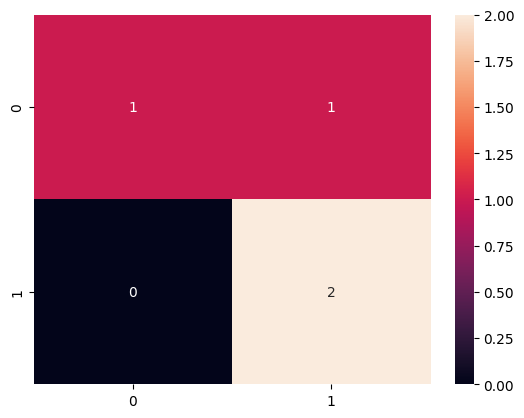

In [16]:
predict = model.predict(val_data)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')


# Quantifying Uncertanty
There are several ways to quantify uncertanty.  

https://imerit.net/blog/a-comprehensive-introduction-to-uncertainty-in-machine-learning-all-una/

## Monte Carlo Dropout
The Monte Carlo method uses random probablities to find the uncertanty.  The Monte Carlo Dropout, uses psudo-random dropouts to create a set of models.  This set of similiar models can be run forward to calculate and analyze the uncertanty.

## Deep Ensembles
Like forrests of trees, this network trains muliple models and caluclates the uncertatny based on the drift between those varied models.  This can do a better job of quantifying uncertanty.  

## Deep Bayesian Active Learning (DBAL)
The baysean Method changes the dese blocks to a Baysean Neural Network.  This allows probabilities to be calculated.

# Going Forward
I wll be using the Monte Carlo Dropout and Deep Baysean Active Learning to calculte the uncertanty.  Deep Ensambles took too long to train the model ensamble.

# Monte Carlo Dropout
To create a Monte Carlo Dropout, take the mode and add dropout layers into them.  There are 3 parts to creating a monte-carlo droput model.  The first is to add dropout layers.  I will add one after each pooling layer.  The second is to have the model use the dropout layer when performing the predict.  The third is to run predict many times to see the variation of different runs with different dropouts.

In [ ]:
with strategy.scope():
  inputs = keras.Input(shape=(imagesize,imagesize,3))
  x = keras.layers.Normalization()(inputs)
  x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Flatten()(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
history = model.fit(train_data, train_targets, epochs=10, batch_size=2, validation_data=(val_data, val_targets), verbose = 0)
predict = model.predict(val_data)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')
# Results to keep the uncertanty results
unified_results = pd.DataFrame('uncertanty_type', 'data')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 169, 169, 3)]     0         
                                                                 
 normalization_1 (Normaliza  (None, 169, 169, 3)       7         
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 167, 167, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 165, 165, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 82, 82, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 82, 82, 64)        0   

In [ ]:
uncertain_samples = np.stack([model(val_data,training=True)
                   for sample in range(100)])
unified_results = unified_results.append({'uncertainty_type': 'Monte-Carlo', 'data': uncertain_samples}, ignore_index=True)
mean = uncertain_samples.mean(axis=0)
std = uncertain_samples.std(axis=0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(mean)
ax[0].set_title('Mean')
ax[1].hist(std)
ax[1].set_title('Standard Deviation')
plt.show()

# Histogram Uncertanty Results

# Baysean Uncertanty
To calculate Baysean Uncertancy, I will repalce the Conv2D and Dense Layers with TensorFlow Probability Blocks that will store baysean uncertanty.  I will also switch the loss funcion to a function that will handle uncertanty.

In [ ]:
import tensorflow_probability as tfp
def sparse_categorical_crossentropy(labels, logits):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
with strategy.scope():
  inputs = keras.Input(shape=(imagesize,imagesize,3))
  x = keras.layers.Normalization()(inputs)
  x = tfp.layers.Convolution2DFlipout(filters=32, kernel_size=3, activation='relu')(x)
  x = tfp.layers.Convolution2DFlipout(filters=64, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = tfp.layers.Convolution2DFlipout(filters=128, kernel_size=3, activation='relu')(x)
  x = tfp.layers.Convolution2DFlipout(filters=256, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Flatten()(x)
  outputs = tfp.layers.DenseFlipout(1, activation='relu')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  model.summary()
history = model.fit(train_data, train_targets, epochs=10, batch_size=2, validation_data=(val_data, val_targets), verbose = 0)
predict = model.predict(val_data)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')